# Classification

In this notebook we will examine classification success of 16S data collected and analyzed in the Nextflow QIIME2 Pipeline

First, we will collect study IDs, stratified by URT collection area

In [1]:
import seaborn as sns
import numpy as np
import glob
import pandas as pd

%matplotlib inline

## Gather QIIME2 artifacts

In [2]:
ids_NP = glob.glob("../data/NP/*_taxonomy.qza")
ids_NP = [i.split("_")[0].split("/")[-1] for i in ids_NP]
ids_OP = glob.glob("../data/OP/*_taxonomy.qza")
ids_OP = [i.split("_")[0].split("/")[-1] for i in ids_OP]

Now we walk through and read the abundance and format everything nicely to a long DataFrame.

In [3]:
import pandas as pd
from rich.progress import track
from plotnine import *
from utils import qiime_to_dataframe

path_NP = "../data/NP"
path_OP = "../data/OP"


data_NP = []
data_OP = []

for pid_NP in track(ids_NP):
    df = qiime_to_dataframe(f"{path_NP}/{pid_NP}_table.qza", f"{path_NP}/{pid_NP}_taxonomy.qza")
    df["study"] = pid_NP
    df["urt"] = 'Nasopharynx'
    data_NP.append(df)
    
for pid_OP in track(ids_OP):
    df = qiime_to_dataframe(f"{path_OP}/{pid_OP}_table.qza", f"{path_OP}/{pid_OP}_taxonomy.qza")
    df["study"] = pid_OP
    df["urt"] = 'Oropharynx'
    data_OP.append(df)

data_NP = pd.concat(data_NP)
data_OP = pd.concat(data_OP)
data = data_NP.append(data_OP,ignore_index = True)
data['study'] = data['study'].str.replace('PRJEB15534','PRJEB22676')

Output()

Output()

/tmp/ipykernel_3816753/2896915376.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


## Classification Percentage
Now, we'll take a look at overall classification percentage for each taxonomic level

In [4]:
data.loc[data.kingdom == "Unassigned", "kingdom"] = None
ranks = ["kingdom", "phylum", "class", "order", "family", "genus"]
cl = pd.Series()
for r in ranks:
    cl[r] = data[data[r].notnull()].reads.sum() / data.reads.sum()
cl

/tmp/ipykernel_3816753/2005634669.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


kingdom    0.932449
phylum     0.924586
class      0.924532
order      0.759268
family     0.751203
genus      0.727627
dtype: float64

## Classification Dataframe
Let's put together a dataframe of classification percentage for each study, at each taxonomic level. 

In [5]:
import numpy as np

# initialize dataframe
classification = pd.DataFrame({'study':[]})
for study in data['study'].unique():
    
    total_reads = data[data['study'].str.contains(study)]['reads'].sum()
    
    # calculate not-null reads divided by total reads in given study at each rank
    classified_reads_species = data[(data['study'].str.contains(study))&
        (data['species'].notnull())]['reads'].sum()/data[data['study'].str.contains(study)]['reads'].sum()
    
    classified_reads_genus = data[(data['study'].str.contains(study))&
        (data['genus'].notnull())]['reads'].sum()/data[data['study'].str.contains(study)]['reads'].sum()
    
    classified_reads_family = data[(data['study'].str.contains(study))&
        (data['family'].notnull())]['reads'].sum()/data[data['study'].str.contains(study)]['reads'].sum()
    
    classified_reads_order = data[(data['study'].str.contains(study))&
        (data['order'].notnull())]['reads'].sum()/data[data['study'].str.contains(study)]['reads'].sum()
    
    classified_reads_class = data[(data['study'].str.contains(study))&
        (data['class'].notnull())]['reads'].sum()/data[data['study'].str.contains(study)]['reads'].sum()
    
    classified_reads_phylum = data[(data['study'].str.contains(study))&
        (data['phylum'].notnull())]['reads'].sum()/data[data['study'].str.contains(study)]['reads'].sum()
    
    classification = pd.concat([classification, pd.DataFrame({
        'study':[study],
        'species':[classified_reads_species],
        'genus':[classified_reads_genus],
        'family':[classified_reads_family],
        'order':[classified_reads_order],
        'class':[classified_reads_class],
        'phylum':[classified_reads_phylum]})
                               ])
# format dataframe 
classification = classification[['study','phylum','class','order','family','genus','species']].set_index('study')
classification = classification*100

# add disease conditions to dataframe
disease = pd.read_csv('../data/studies.csv', header = None, index_col = 0)[2].to_dict()
classification['disease'] = classification.index.map(disease)

classification = classification.sort_values(by = 'disease')

## Plot Classification 
Now we'll plot the classification percentage for each study at each level on a heatmap, using Seaborn. We'll add a color bar signifying disease type

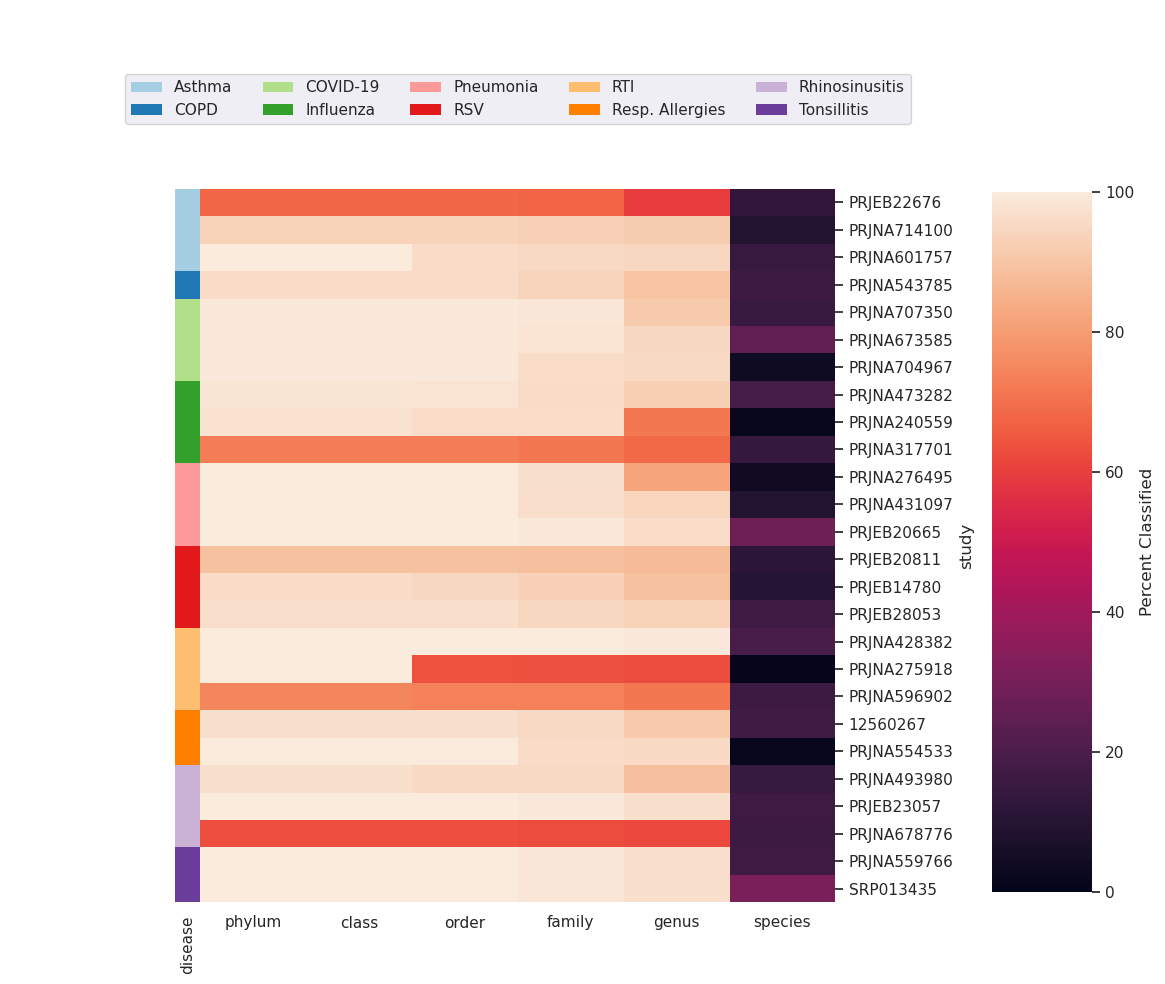

In [6]:
import seaborn as sns
import matplotlib as plt

%matplotlib inline

palette = sns.color_palette("Paired", 11)
lut = dict(zip(classification['disease'].unique(),palette))
row_colors = classification['disease'].map(lut)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.clustermap(classification[['phylum','class','order','family','genus','species']],vmin = 0, 
                    vmax = 100, row_colors=row_colors,row_cluster = False,col_cluster = False,
                    cbar_pos=[1,0.1,.1,.7],cbar_kws={'label':'Percent Classified'})

for label in classification['disease'].unique():
    ax.ax_col_dendrogram.bar(0, 0, color=lut[label],
                            label=label, linewidth=0)
ax.ax_col_dendrogram.legend(loc="center", ncol=5)
ax

## Phyla Distribution
That looks good! Let's look at the phyla distributions on a heatmap. Again we'll use seaborn, and plot phylum abundance for each sample across all studies. 

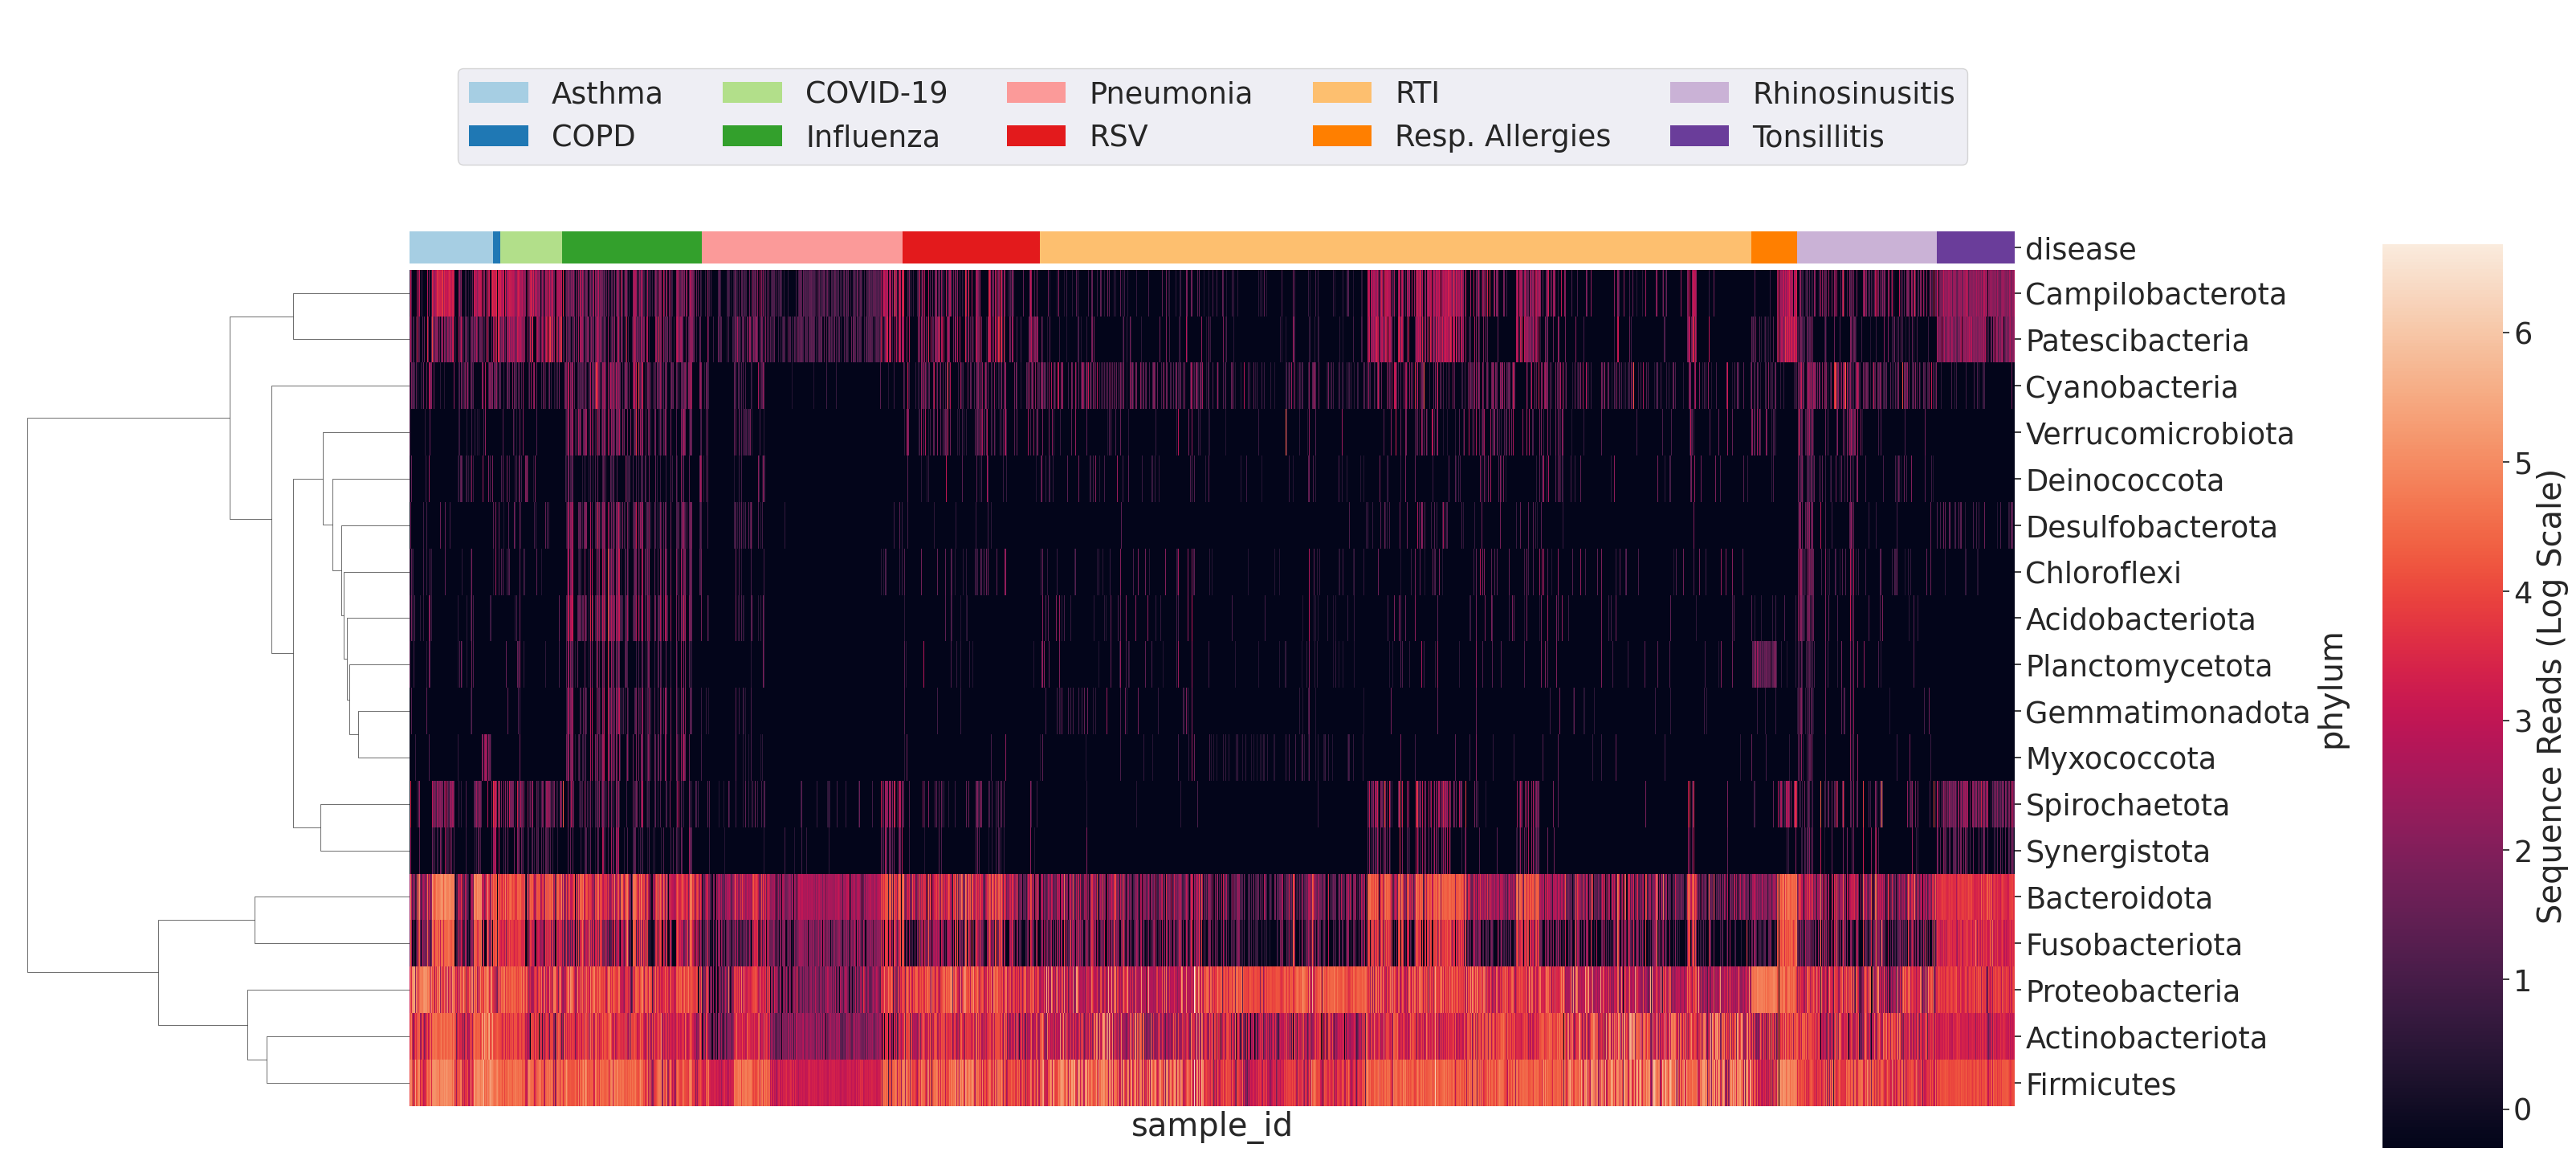

In [7]:

#pivot data table to phylum abundances 
mat = pd.pivot_table(
    data[(data.kingdom == "Bacteria") & data.genus.notnull()], 
    index="sample_id", 
    values="reads", 
    columns="phylum", 
    aggfunc=sum, 
    fill_value=0.0
)

mat = mat[mat.columns[mat.mean(axis=0) > 5]]
study_dict = data.set_index('sample_id')['study'].to_dict()
mat['study'] = mat.index.map(study_dict)
mat['disease'] = mat['study'].map(disease)
mat = mat.sort_values(by = 'disease')

lut = dict(zip(mat['disease'].unique(),palette))
row_colors = mat['disease'].map(lut)
sns.set(font_scale=2.4)
x = sns.clustermap(np.log10(mat.iloc[:,:-2].T+0.5), yticklabels=True, 
                   col_colors = row_colors, col_cluster = False, xticklabels=False, 
                   cbar_pos=[1,0.025,.05,.75],figsize=(30, 15), cbar_kws={'label':'Sequence Reads (Log Scale)'})

for label in mat['disease'].unique():
    x.ax_col_dendrogram.bar(0, 0, color=lut[label],
                            label=label, linewidth=0)
x.ax_col_dendrogram.legend(loc="center", ncol=5)